In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import re
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
import catboost as cab

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import warnings
import json 
import pickle
warnings.filterwarnings('ignore')

import torch
import pickle
import random

import sentence_transformers 
from sklearn.preprocessing import KBinsDiscretizer
from sentence_transformers import SentenceTransformer

from gensim.models import Word2Vec

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Dataset

In [2]:
products_encoded = pd.read_csv('./data/products_encoded.csv')

In [3]:
num_features = ['price', 'len_title', 'len_desc']

In [4]:
products_encoded[num_features].head()

,price,len_title,len_desc
0,30.95,96.0,121.0
1,17.90,186.0,330.0
2,68.89,181.0,95.0
3,18.99,101.0,191.0
4,7.17,45.0,15.0


In [5]:
for fe in num_features:
    products_encoded.loc[:, fe] = products_encoded.loc[:, fe].astype('float32')

In [6]:
products_encoded[num_features].head()

,price,len_title,len_desc
0,30.950001,96.0,121.0
1,17.900000,186.0,330.0
2,68.889999,181.0,95.0
3,18.990000,101.0,191.0
4,7.170000,45.0,15.0


数据读取

In [13]:
# (3606249, 3)
df_train = pd.read_csv('data/sessions_train.csv')
df_train

,prev_items,next_item,locale
0,['B09W9FND7K' 'B09JSPLN1M'],B09M7GY217,DE
1,['B076THCGSG' 'B007MO8IME' 'B08MF65MLV' 'B001B...,B001B4THSA,DE
2,['B0B1LGXWDS' 'B00AZYORS2' 'B0B1LGXWDS' 'B00AZ...,B0767DTG2Q,DE
3,['B09XMTWDVT' 'B0B4MZZ8MB' 'B0B7HZ2GWX' 'B09XM...,B0B4R9NN4B,DE
4,['B09Y5CSL3T' 'B09Y5DPTXN' 'B09FKD61R8'],B0BGVBKWGZ,DE
...,...,...,...
3606244,['B086CYFSKW' 'B0874F9859' 'B086CYFSKW'],B07B5TYD76,IT
3606245,['B09NRZKZ7V' 'B08WJTPV93'],B08L1P4C3D,IT
3606246,['B085JFX7MP' 'B085JGHW8R'],B01MPWVD44,IT
3606247,['B00B0UING2' 'B00B0UING2'],B00D3HYEZ4,IT


In [2]:
# (316971, 2)
df_test = pd.read_csv('data/phase2/sessions_test_task1.csv')
df_test

,prev_items,locale
0,['B087VLP2RT' 'B09BRQSHYH' 'B099KW4ZLV'],DE
1,['B08XW4W667' 'B096VMCJYF' 'B096VMCJYF'],DE
2,['B09Z4T2GJ3' 'B09Z3FBXMB' 'B0936K9LTJ' 'B09Z4...,DE
3,['B07T6Y2HG7' 'B07T2NBLX9' 'B07Y1G5F3Y'],DE
4,['B0B2DRKZ6X' 'B0B2DRKZ6X' 'B0B2DRKZ6X'],DE
...,...,...
316967,['B078RJX3CC' 'B07GKM97YF'],UK
316968,['B01LX5Y7RG' 'B00M35Y2J0' 'B0BFR9D1Y2' 'B09BB...,UK
316969,['B09HGRXXTM' 'B08VDNCZT9'],UK
316970,['B089CVQ2FS' 'B089CVQ2FS'],UK


In [17]:
# (316971, 2)
df_test = pd.read_csv('data/phase2/sessions_test_task2.csv')
df_test

,prev_items,locale
0,['B07GTS7SWK' 'B07GTS7SWK'],ES
1,['B0B33YWVHR' '849988993X' 'B09QQG85HM' 'B0BJZ...,ES
2,['B08FMPXDTJ' 'B0B4612MTM' 'B0B45YR21M' 'B0B4F...,ES
3,['B07R3W4XQ7' 'B07R3FB5B5'],ES
4,['B09V4KBWPL' 'B09G9FTLPB'],ES
...,...,...
34685,['B089F3YK6X' 'B01BBW9TEI' 'B01BBW9Q46'],IT
34686,['B078XYC42V' 'B09TW31SND'],IT
34687,['B07ZG3V3X2' 'B09PGKF9Y8'],IT
34688,['B0B3JRGZLM' 'B09SHQJ8NV'],IT


In [14]:
def str2list(x):
    x = x.replace('[', '').replace(']', '').replace("'", '').replace('\n', ' ').replace('\r', ' ')
    l = [i for i in x.split() if i]
    return l

In [19]:
df_test['prev_items'] = df_test['prev_items'].apply(lambda x: str2list(x))

In [15]:
df_train['prev_items'] = df_train['prev_items'].apply(lambda x: str2list(x))


In [16]:
df_train['length'] = df_train['prev_items'].apply(len)

In [18]:
df_train['length'].describe()

count    3.606249e+06
mean     4.244350e+00
std      3.548881e+00
min      2.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      4.740000e+02
Name: length, dtype: float64

In [23]:
df_train['length'][df_train['length'] < 50]

0          2
1          4
2          9
3          7
4          3
          ..
3606244    3
3606245    2
3606246    2
3606247    2
3606248    4
Name: length, Length: 3605555, dtype: int64

In [26]:
(df_train['length'] < 20).sum() / len(df_train)

0.9921647118654313

<AxesSubplot:ylabel='Frequency'>

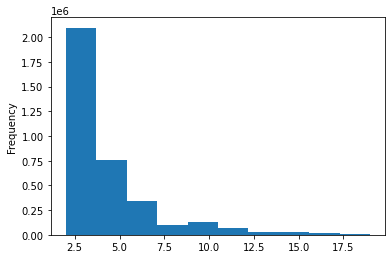

In [27]:
df_train['length'][df_train['length'] < 20].plot.hist()

In [29]:
df_train['length'].mean()

4.244350015764303

In [10]:
# 1min多一些
df_train['prev_items'] = df_train['prev_items'].apply(lambda x: str2list(x))
df_test['prev_items'] = df_test['prev_items'].apply(lambda x: str2list(x))

In [11]:
df_train

,prev_items,next_item,locale
0,"[B09W9FND7K, B09JSPLN1M]",B09M7GY217,DE
1,"[B076THCGSG, B007MO8IME, B08MF65MLV, B001B4TKA0]",B001B4THSA,DE
2,"[B0B1LGXWDS, B00AZYORS2, B0B1LGXWDS, B00AZYORS...",B0767DTG2Q,DE
3,"[B09XMTWDVT, B0B4MZZ8MB, B0B7HZ2GWX, B09XMTWDV...",B0B4R9NN4B,DE
4,"[B09Y5CSL3T, B09Y5DPTXN, B09FKD61R8]",B0BGVBKWGZ,DE
...,...,...,...
3606244,"[B086CYFSKW, B0874F9859, B086CYFSKW]",B07B5TYD76,IT
3606245,"[B09NRZKZ7V, B08WJTPV93]",B08L1P4C3D,IT
3606246,"[B085JFX7MP, B085JGHW8R]",B01MPWVD44,IT
3606247,"[B00B0UING2, B00B0UING2]",B00D3HYEZ4,IT


In [20]:
df_test['last_item'] = df_test['prev_items'].apply(lambda x: x[-1])

In [12]:
df_train['last_item'] = df_train['prev_items'].apply(lambda x: x[-1])
df_test['last_item'] = df_test['prev_items'].apply(lambda x: x[-1])

In [13]:
df_train.shape, df_test.shape 

((3606249, 4), (316971, 3))

In [21]:
df_test.shape 

(34690, 3)

In [7]:
loc2id = {
    'DE': 0,
    'JP': 1,
    'UK': 2,
    'ES': 3,
    'FR': 4,
    'IT': 5
}

In [8]:
loc2id = {'DE': 0, 'JP': 1, 'UK': 2, 'ES': 3, 'FR': 4, 'IT': 5}

In [15]:
train_ids = np.load('data/train_ids.npy')
test_ids = np.load('data/test_ids.npy')

In [ ]:
total_ids = set(train_ids) | set(test_ids)
len(total_ids)

产品特征处理

In [2]:
# 不到1min (1551057, 11)
products = pd.read_csv('data/products_train.csv')
products

,id,locale,title,price,brand,color,size,model,material,author,desc
0,B005ZSSN10,DE,RED DRAGON Amberjack 3 - Steel Tip 22 Gramm Wo...,30.95,RED DRAGON,NaN,NaN,RDD0089,NaN,NaN,Amberjacks Steel Dartpfeile sind verfügbar in ...
1,B08PRYN6LD,DE,Simply Keto Lower Carb* Schokodrops ohne Zucke...,17.90,Simply Keto,NaN,750 g (1er Pack),NaN,NaN,NaN,🌱 NATÜRLICHE SÜSSE DURCH ERYTHRIT - Wir stelle...
2,B09MBZJ48V,DE,"Sennheiser 508377 PC 5.2 Chat, Stilvolles Mult...",68.89,Sennheiser,Multi-Colour,One size,508377,Kunstleder,NaN,3.5 MM BUCHSE - Kann problemlos an Geräte mit ...
3,B08ZN6F26S,DE,AmyBenton Auto ab 1 2 3 ahre - Baby Aufziehbar...,18.99,Amy & Benton,Animal Car,NaN,2008B,aufziehauto 1 jahr,NaN,【Auto aufziehbar】: Drücken Sie einfach leicht ...
4,B094DGRV7D,DE,PLAYMOBIL - 70522 - Cavaliere mit grauem Pony,7.17,PLAYMOBIL,Nicht Zutreffend.,OneSize,70522,Polypropylen,NaN,Inhalt: 1 Stück
...,...,...,...,...,...,...,...,...,...,...,...
1551052,B09BW5CDRR,IT,Barbie - Playset Gelateria con Bambola con Mac...,20.48,Barbie,NaN,NaN,HCN46,NaN,NaN,DETTAGLI REALISTICI. Basta inserire la pasta m...
1551053,B0050IILBM,IT,"Braun Silk-épil 1 Depilatore Donna, Epilatore ...",22.61,Braun,Pink,NaN,4210201656067,NaN,NaN,Alimentato a corrente per un comodo utilizzo
1551054,B07W4C5W9D,IT,BoxLegend Sacchetti Sottovuoto Vestiti 6 Pezzi...,14.99,BoxLegend,6 Pezzi.,6 Pezzi (2L + 2M + 2S),6186666487608_SML,Polietilene Ppa,NaN,6 Sacchetti in 3 Diverse Misure- Questo set di...
1551055,B012D0HJXA,IT,Trasportino Pratiko Metal - Accessorio da viag...,18.35,MPS,verde,NaN,NaN,Metallo,NaN,TRASPORTINO 48X31.5X33CM


In [3]:
products.head()

,id,locale,title,price,brand,color,size,model,material,author,desc
0,B005ZSSN10,DE,RED DRAGON Amberjack 3 - Steel Tip 22 Gramm Wo...,30.95,RED DRAGON,NaN,NaN,RDD0089,NaN,NaN,Amberjacks Steel Dartpfeile sind verfügbar in ...
1,B08PRYN6LD,DE,Simply Keto Lower Carb* Schokodrops ohne Zucke...,17.90,Simply Keto,NaN,750 g (1er Pack),NaN,NaN,NaN,🌱 NATÜRLICHE SÜSSE DURCH ERYTHRIT - Wir stelle...
2,B09MBZJ48V,DE,"Sennheiser 508377 PC 5.2 Chat, Stilvolles Mult...",68.89,Sennheiser,Multi-Colour,One size,508377,Kunstleder,NaN,3.5 MM BUCHSE - Kann problemlos an Geräte mit ...
3,B08ZN6F26S,DE,AmyBenton Auto ab 1 2 3 ahre - Baby Aufziehbar...,18.99,Amy & Benton,Animal Car,NaN,2008B,aufziehauto 1 jahr,NaN,【Auto aufziehbar】: Drücken Sie einfach leicht ...
4,B094DGRV7D,DE,PLAYMOBIL - 70522 - Cavaliere mit grauem Pony,7.17,PLAYMOBIL,Nicht Zutreffend.,OneSize,70522,Polypropylen,NaN,Inhalt: 1 Stück


In [ ]:
products_ids = products['id'].unique().tolist()

In [ ]:
len_ids = len(products_ids)

len_ids

1410675

In [ ]:
# 可以把训练lgb的那些聚合出来的序列特征，比如平均价格之类的，MLP之后拼接到RNN的输出，一起做预测之类的

In [ ]:
duplicated_rows = products[products.duplicated(subset=['id'], keep=False)]

In [ ]:
duplicated_rows = duplicated_rows.sort_values('id')

In [36]:
duplicated_rows.to_csv('data/duplicated_products.csv', index=False)

In [4]:
products.drop_duplicates(subset=['id'], keep='first', inplace=True)
products.shape 

(1410675, 11)

In [5]:
products.head()

,id,locale,title,price,brand,color,size,model,material,author,desc
0,B005ZSSN10,DE,RED DRAGON Amberjack 3 - Steel Tip 22 Gramm Wo...,30.95,RED DRAGON,NaN,NaN,RDD0089,NaN,NaN,Amberjacks Steel Dartpfeile sind verfügbar in ...
1,B08PRYN6LD,DE,Simply Keto Lower Carb* Schokodrops ohne Zucke...,17.90,Simply Keto,NaN,750 g (1er Pack),NaN,NaN,NaN,🌱 NATÜRLICHE SÜSSE DURCH ERYTHRIT - Wir stelle...
2,B09MBZJ48V,DE,"Sennheiser 508377 PC 5.2 Chat, Stilvolles Mult...",68.89,Sennheiser,Multi-Colour,One size,508377,Kunstleder,NaN,3.5 MM BUCHSE - Kann problemlos an Geräte mit ...
3,B08ZN6F26S,DE,AmyBenton Auto ab 1 2 3 ahre - Baby Aufziehbar...,18.99,Amy & Benton,Animal Car,NaN,2008B,aufziehauto 1 jahr,NaN,【Auto aufziehbar】: Drücken Sie einfach leicht ...
4,B094DGRV7D,DE,PLAYMOBIL - 70522 - Cavaliere mit grauem Pony,7.17,PLAYMOBIL,Nicht Zutreffend.,OneSize,70522,Polypropylen,NaN,Inhalt: 1 Stück


In [6]:
products['len_title'] = products['title'].apply(lambda x : 0 if type(x) == float else len(x))
products['len_desc'] = products['desc'].apply(lambda x : 0 if type(x) == float else len(x))

In [7]:
products.columns

Index(['id', 'locale', 'title', 'price', 'brand', 'color', 'size', 'model',
       'material', 'author', 'desc', 'len_title', 'len_desc'],
      dtype='object')

In [8]:
cat_features = ['brand', 'color', 'size', 'model', 'material', 'author']
num_features = ['price', 'len_title', 'len_desc']

In [ ]:
for f in cat_features:
    le = LabelEncoder()
    products['encode_' + f] = le.fit_transform(products[f])

In [16]:
products.price.describe()

count    1.410675e+06
mean     1.879798e+06
std      8.462341e+06
min      0.000000e+00
25%      1.124000e+01
50%      2.460000e+01
75%      9.900000e+02
max      4.000000e+07
Name: price, dtype: float64

In [ ]:
dense_bins = 10
add_cat_features = []
for f in num_features:
    discretizer = KBinsDiscretizer(n_bins=dense_bins, encode='ordinal', strategy='kmeans')  # 等频quantile，等宽uniform
    products['encode_' + f] = discretizer.fit_transform(np.array(products[f].tolist()).reshape(-1, 1))
    add_cat_features.append('encode_' + f)

In [ ]:
for fe in add_cat_features:
    products[fe] = products[fe].astype('int64')

In [ ]:
num_features = ['price', 'len_title', 'len_desc']
for fe in num_features:
    products[fe] = products[fe].astype('float32')

In [ ]:
add_cat_features

['encode_price', 'encode_len_title', 'encode_len_desc']

In [ ]:
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
sentence_model.to('cuda:1')

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [ ]:
titles = products['title'].values
titles_embedding = []

In [ ]:
descs = products['desc'].values
descs_embedding = []

In [90]:
for s in tqdm(titles, total=len(titles)):
    if type(s) == float:
        titles_embedding.append(np.zeros(titles_embedding[-1].shape))
    else:
        titles_embedding.append(sentence_model.encode(s))

100%|██████████| 1410675/1410675 [2:11:56<00:00, 178.20it/s] 


In [91]:
for s in tqdm(descs, total=len(descs)):
    if type(s) == float:
        descs_embedding.append(np.zeros(descs_embedding[-1].shape))
    else:
        descs_embedding.append(sentence_model.encode(s))

100%|██████████| 1410675/1410675 [2:03:08<00:00, 190.93it/s] 


In [92]:
np.save('./data/titles_embedding.npy', titles_embedding)

In [93]:
np.save('./data/descs_embedding.npy', descs_embedding)

In [2]:
titles_embedding = np.load('./data/titles_embedding.npy')
descs_embedding = np.load('./data/descs_embedding.npy')
titles_embedding.shape, descs_embedding.shape 

((1410675, 384), (1410675, 384))

In [3]:
from sklearn.decomposition import PCA

In [5]:
# 创建PCA对象，并指定目标维度d
pca = PCA(n_components=64)

# 将原始数据X进行降维
titles_embedding_reduced = pca.fit_transform(titles_embedding)

In [6]:
# 创建PCA对象，并指定目标维度d
pca = PCA(n_components=64)

# 将原始数据X进行降维
descs_embedding_reduced = pca.fit_transform(descs_embedding)

In [7]:
titles_embedding_reduced.shape, descs_embedding_reduced.shape 

((1410675, 64), (1410675, 64))

In [9]:
np.save('./data/titles_embedding_reduced_64.npy', titles_embedding_reduced)
np.save('./data/descs_embedding_reduced_64.npy', descs_embedding_reduced)

In [10]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import manifold
import argparse
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


(1410675, 64)


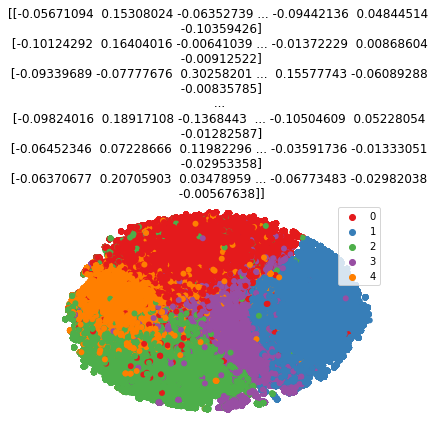

In [11]:
def get_res(vector, n_clusters):
    print(vector.shape)

    k_means = KMeans(n_clusters=n_clusters, random_state=10)
    k_means.fit(vector)
    labels = k_means.labels_
    y_predict = k_means.predict(vector)

    # TSNE可视化
    x_input_tsne = normalize(vector, norm='l2', axis=1)  # 按行归一化
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)  # n_components=2降维为2维并且可视化
    x_tsne = tsne.fit_transform(x_input_tsne)
    # x_min, x_max = x_tsne.min(0), x_tsne.max(0)
    # x_norm = (x_tsne - x_min) / (x_max - x_min)  # 归一化
    return x_tsne, y_predict


# plt.figure()
# x_norm, y_predict = get_res(X, n_clusters=5)
# sns.scatterplot(x=x_norm[:, 0], y=x_norm[:, 1], hue=y, palette='Set1', legend=True, linewidth=0, sizes=(100,100))
# plt.axis('off')
# plt.title(item_type)
# plt.show()

plt.figure()
x_norm, y_predict = get_res(titles_embedding_reduced, n_clusters=5)
sns.scatterplot(x=x_norm[:, 0], y=x_norm[:, 1], hue=y_predict, palette='Set1', legend=True, linewidth=0, sizes=(100,100))
plt.axis('off')
plt.title(titles_embedding_reduced)
plt.show()

(1410675, 64)


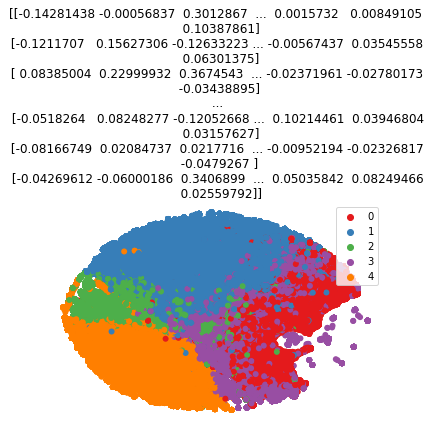

In [12]:
def get_res(vector, n_clusters):
    print(vector.shape)

    k_means = KMeans(n_clusters=n_clusters, random_state=10)
    k_means.fit(vector)
    labels = k_means.labels_
    y_predict = k_means.predict(vector)

    # TSNE可视化
    x_input_tsne = normalize(vector, norm='l2', axis=1)  # 按行归一化
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)  # n_components=2降维为2维并且可视化
    x_tsne = tsne.fit_transform(x_input_tsne)
    # x_min, x_max = x_tsne.min(0), x_tsne.max(0)
    # x_norm = (x_tsne - x_min) / (x_max - x_min)  # 归一化
    return x_tsne, y_predict


# plt.figure()
# x_norm, y_predict = get_res(X, n_clusters=5)
# sns.scatterplot(x=x_norm[:, 0], y=x_norm[:, 1], hue=y, palette='Set1', legend=True, linewidth=0, sizes=(100,100))
# plt.axis('off')
# plt.title(item_type)
# plt.show()

plt.figure()
x_norm, y_predict = get_res(descs_embedding_reduced, n_clusters=5)
sns.scatterplot(x=x_norm[:, 0], y=x_norm[:, 1], hue=y_predict, palette='Set1', legend=True, linewidth=0, sizes=(100,100))
plt.axis('off')
plt.title(descs_embedding_reduced)
plt.show()

In [30]:
products['locale'] = products['locale'].apply(lambda x: loc2id[x])

In [31]:
products.head()

,id,locale,title,price,brand,color,size,model,material,author,...,len_desc,encode_brand,encode_color,encode_size,encode_model,encode_material,encode_author,encode_price,encode_len_title,encode_len_desc
0,B005ZSSN10,0,RED DRAGON Amberjack 3 - Steel Tip 22 Gramm Wo...,30.950001,RED DRAGON,NaN,NaN,RDD0089,NaN,NaN,...,121.0,112134,203260,218060,426630,45568,30835,0,2,2
1,B08PRYN6LD,0,Simply Keto Lower Carb* Schokodrops ohne Zucke...,17.900000,Simply Keto,NaN,750 g (1er Pack),NaN,NaN,NaN,...,330.0,124505,203260,128007,524101,45568,30835,0,4,5
2,B09MBZJ48V,0,"Sennheiser 508377 PC 5.2 Chat, Stilvolles Mult...",68.889999,Sennheiser,Multi-Colour,One size,508377,Kunstleder,NaN,...,95.0,122979,114264,170270,145013,15566,30835,0,4,1
3,B08ZN6F26S,0,AmyBenton Auto ab 1 2 3 ahre - Baby Aufziehbar...,18.990000,Amy & Benton,Animal Car,NaN,2008B,aufziehauto 1 jahr,NaN,...,191.0,9834,46931,218060,67408,29357,30835,0,2,3
4,B094DGRV7D,0,PLAYMOBIL - 70522 - Cavaliere mit grauem Pony,7.170000,PLAYMOBIL,Nicht Zutreffend.,OneSize,70522,Polypropylen,NaN,...,15.0,105135,117844,170305,174527,23064,30835,0,0,0


In [32]:
products.shape

(1410675, 22)

In [1]:
features = [f for f in products.columns if f not in ['title', 'desc'] + cat_features]
len(features)

NameError: name 'products' is not defined

In [291]:
products.to_csv('./data/products_processed.csv', index=False)

In [9]:
products[features]

NameError: name 'features' is not defined

In [35]:
products.columns 

Index(['id', 'locale', 'title', 'price', 'brand', 'color', 'size', 'model',
       'material', 'author', 'desc', 'len_title', 'len_desc', 'encode_brand',
       'encode_color', 'encode_size', 'encode_model', 'encode_material',
       'encode_author', 'encode_price', 'encode_len_title', 'encode_len_desc'],
      dtype='object')

ID映射

In [124]:
product2id = {}
id2product = {}

for ind, id_ in enumerate(tqdm(products['id'].values, total=len(products['id']))):
    product2id[id_] = ind
    id2product[ind] = id_

100%|██████████| 1410675/1410675 [00:01<00:00, 1173467.39it/s]


In [127]:
json.dump(product2id, open('data/product2id.json', 'w'))
json.dump(id2product, open('data/id2product.json', 'w'))

In [9]:
product2id = json.load(open('data/product2id.json', 'r'))
id2product = json.load(open('data/id2product.json', 'r'))
id2product = {int(k): v for k, v in id2product.items()}

In [43]:
df_train.shape, df_test.shape 

((3606249, 4), (316971, 3))

In [10]:
df_test.head()

,prev_items,locale,last_item
0,"[B087VLP2RT, B09BRQSHYH, B099KW4ZLV]",DE,B099KW4ZLV
1,"[B08XW4W667, B096VMCJYF, B096VMCJYF]",DE,B096VMCJYF
2,"[B09Z4T2GJ3, B09Z3FBXMB, B0936K9LTJ, B09Z4PYG8Q]",DE,B09Z4PYG8Q
3,"[B07T6Y2HG7, B07T2NBLX9, B07Y1G5F3Y]",DE,B07Y1G5F3Y
4,"[B0B2DRKZ6X, B0B2DRKZ6X, B0B2DRKZ6X]",DE,B0B2DRKZ6X


In [22]:
df_test_encoded = df_test.copy()
df_test_encoded['locale'] = df_test_encoded['locale'].map(loc2id)
df_test_encoded['last_item'] = df_test_encoded['last_item'].map(product2id)
df_test_encoded['prev_items'] = df_test_encoded['prev_items'].apply(lambda x: [product2id[id_] for id_ in x])

In [23]:
df_test_encoded.head()

,prev_items,locale,last_item
0,"[19467, 19467]",3,19467
1,"[1343348, 1345836, 12637, 1358569, 274317, 136...",3,1361461
2,"[1350232, 1355892, 1342513, 1343179, 1355892, ...",3,1342513
3,"[1349431, 1358937]",3,1358937
4,"[1349811, 1356085]",3,1356085


In [47]:
df_train.head()

,prev_items,next_item,locale,last_item
0,"[B09W9FND7K, B09JSPLN1M]",B09M7GY217,DE,B09JSPLN1M
1,"[B076THCGSG, B007MO8IME, B08MF65MLV, B001B4TKA0]",B001B4THSA,DE,B001B4TKA0
2,"[B0B1LGXWDS, B00AZYORS2, B0B1LGXWDS, B00AZYORS...",B0767DTG2Q,DE,B00AZYORS2
3,"[B09XMTWDVT, B0B4MZZ8MB, B0B7HZ2GWX, B09XMTWDV...",B0B4R9NN4B,DE,B0B71CHT1L
4,"[B09Y5CSL3T, B09Y5DPTXN, B09FKD61R8]",B0BGVBKWGZ,DE,B09FKD61R8


In [48]:
df_train_encoded = df_train
df_train_encoded['locale'] = df_train_encoded['locale'].map(loc2id)
df_train_encoded['last_item'] = df_train_encoded['last_item'].map(product2id)
df_train_encoded['next_item'] = df_train_encoded['next_item'].map(product2id)
df_train_encoded['prev_items'] = df_train_encoded['prev_items'].apply(lambda x: [product2id[id_] for id_ in x])

In [49]:
df_train.head()

,prev_items,next_item,locale,last_item
0,"[265193, 83226]",387776,0,83226
1,"[38788, 85634, 4132, 71046]",335301,0,71046
2,"[191882, 516876, 191882, 516876, 191882, 19188...",90141,0,516876
3,"[136959, 261145, 31496, 136959, 261145, 31496,...",214540,0,469511
4,"[291068, 410614, 4219]",338089,0,4219


In [50]:
id_count = products.shape[0]
id_count

1410675

In [51]:
products_encoded = products[features]

In [52]:
products_encoded['id'] = products_encoded['id'].map(product2id)

In [53]:
products_encoded.head()

,id,locale,price,len_title,len_desc,encode_brand,encode_color,encode_size,encode_model,encode_material,encode_author,encode_price,encode_len_title,encode_len_desc
0,0,0,30.950001,96.0,121.0,112134,203260,218060,426630,45568,30835,0,2,2
1,1,0,17.900000,186.0,330.0,124505,203260,128007,524101,45568,30835,0,4,5
2,2,0,68.889999,181.0,95.0,122979,114264,170270,145013,15566,30835,0,4,1
3,3,0,18.990000,101.0,191.0,9834,46931,218060,67408,29357,30835,0,2,3
4,4,0,7.170000,45.0,15.0,105135,117844,170305,174527,23064,30835,0,0,0


Word2vec

In [144]:
def get_seq(df_sess_loc, df_test_loc):
    res = []
    for _, row in tqdm(df_sess_loc.iterrows(), total=len(df_sess_loc)):
        prev_items = row['prev_items']
        next_item = row['next_item']
        prev_items.append(next_item)
        res.append(prev_items)
    
    for _, row in tqdm(df_test_loc.iterrows(), total=len(df_test_loc)):
        prev_items = row['prev_items']
        res.append(prev_items)
    
    return res 

In [145]:
id_seqs = get_seq(df_train_encoded, df_test_encoded)

100%|██████████| 316971/316971 [00:17<00:00, 17684.62it/s]


In [146]:
np.save('./data/id_seqs.npy', id_seqs)

In [54]:
w2v_window = 3
w2v_min_count = 1
w2v_epochs = 500
w2v_vector_size = 128

In [148]:
id_word2vec = Word2Vec(sentences=id_seqs, window=w2v_window, min_count=w2v_min_count, workers=40, epochs=w2v_epochs, vector_size=w2v_vector_size)

In [154]:
id_word2vec.wv.save_word2vec_format('./data/word2vec_{}_{}_{}_{}.txt'.format(w2v_vector_size, w2v_epochs, w2v_window, w2v_min_count))

In [ ]:
id_word2vec.save('./data/word2vec_{}_{}_{}_{}.pt'.format(w2v_vector_size, w2v_epochs, w2v_window, w2v_min_count))

In [55]:
id_word2vec = Word2Vec.load('./data/word2vec_{}_{}_{}_{}.pt'.format(w2v_vector_size, w2v_epochs, w2v_window, w2v_min_count))

In [56]:
word2vec_embedding = []
for word in tqdm(range(id_count)):
    try:
        word2vec_embedding.append(id_word2vec.wv[word])
    except:
        # 部分word没有出现在id_seqs里边，就是不存在历史的那些id
        print(word)
        word2vec_embedding.append(np.zeros(w2v_vector_size))

100%|██████████| 1410675/1410675 [00:03<00:00, 358352.92it/s]

1405867
1405878
1405945
1405974
1406057
1406093
1406100
1406105
1406131
1406163
1406216
1406225
1406264
1406326
1406338
1406353
1406367
1406398
1406417
1406418
1406442
1406462
1406477
1406498
1406522
1406527
1406545
1406571
1406617
1406634
1406650
1406666
1406667
1406688
1406713
1406729
1406735
1406736
1406780
1406834
1406882
1406925
1406931
1406932
1406939
1406941
1406979
1406989
1407032
1407058
1407099
1407108
1407130
1407131
1407141
1407143
1407168
1407179
1407220
1407225
1407230
1407237
1407246
1407261
1407267
1407280
1407312
1407322
1407337
1407353
1407438
1407463
1407472
1407479
1407491
1407502
1407557
1407582
1407606
1407630
1407642
1407674
1407713
1407740
1407757
1407855
1407864
1407881
1407885
1407887
1407907
1407918
1407929
1407970
1407972
1407980
1408010
1408020
1408050
1408051
1408065
1408090
1408125
1408130
1408132
1408149
1408184
1408198
1408199
1408206
1408236
1408259
1408289
1408404
1408434
1408443
1408496
1408529
1408538
1408550
1408641
1408643
1408699
1408729
1408747


In [351]:
np.save('./data/word2vec_embedding.npy', word2vec_embedding)

In [57]:
word2vec_embedding = np.load('./data/word2vec_embedding.npy')
word2vec_embedding.shape 

(1410675, 128)

召回

In [59]:
df_train_encoded.head()

,prev_items,next_item,locale,last_item
0,"[265193, 83226]",387776,0,83226
1,"[38788, 85634, 4132, 71046]",335301,0,71046
2,"[191882, 516876, 191882, 516876, 191882, 19188...",90141,0,516876
3,"[136959, 261145, 31496, 136959, 261145, 31496,...",214540,0,469511
4,"[291068, 410614, 4219]",338089,0,4219


In [16]:
df_test_encoded.head()

,prev_items,locale,last_item
0,"[30854, 296715, 240994]",0,240994
1,"[79751, 426496, 426496]",0,426496
2,"[243200, 283983, 367639, 257230]",0,257230
3,"[170646, 280251, 165573]",0,165573
4,"[303141, 303141, 303141]",0,303141


In [61]:
products_encoded.head()

,id,locale,price,len_title,len_desc,encode_brand,encode_color,encode_size,encode_model,encode_material,encode_author,encode_price,encode_len_title,encode_len_desc
0,0,0,30.950001,96.0,121.0,112134,203260,218060,426630,45568,30835,0,2,2
1,1,0,17.900000,186.0,330.0,124505,203260,128007,524101,45568,30835,0,4,5
2,2,0,68.889999,181.0,95.0,122979,114264,170270,145013,15566,30835,0,4,1
3,3,0,18.990000,101.0,191.0,9834,46931,218060,67408,29357,30835,0,2,3
4,4,0,7.170000,45.0,15.0,105135,117844,170305,174527,23064,30835,0,0,0


In [74]:
df_train_encoded.shape, df_test_encoded.shape

((3606249, 5), (316971, 3))

In [ ]:
# TODO: 训练集的部分样本召回的时候，没有找到真实的label。这些对于训练来说就没有用了！修改一下，看看要不要直接把label加进去

In [63]:
# 召回的结果
train_preds = pickle.load(open('./data/train_preds_all.pkl', 'rb'))
test_preds = pickle.load(open('./data/test_preds_all.pkl', 'rb'))
len(train_preds), len(test_preds)

In [200]:
train_preds_encoded = []
for x in train_preds:
    train_preds_encoded.append([product2id[id_] for id_ in x])

In [201]:
test_preds_encoded = []
for x in test_preds:
    test_preds_encoded.append([product2id[id_] for id_ in x])

In [202]:
len(train_preds_encoded), len(test_preds_encoded)

(3606249, 316971)

In [205]:
pickle.dump(train_preds_encoded, open('./data/train_preds_all_encoded.pkl', 'wb'))
pickle.dump(test_preds_encoded, open('./data/test_preds_all_encoded.pkl', 'wb'))

In [66]:
train_preds_encoded = pickle.load(open('./data/train_preds_all_encoded.pkl', 'rb'))
test_preds_encoded = pickle.load(open('./data/test_preds_all_encoded.pkl', 'rb'))

In [77]:
df_train_encoded['recall'] = train_preds_encoded
df_test_encoded['recall'] = test_preds_encoded

In [68]:
df_train_encoded.head()

,prev_items,next_item,locale,last_item,recall
0,"[265193, 83226]",387776,0,83226,"[265193, 387776, 174133, 54056, 236419, 374995..."
1,"[38788, 85634, 4132, 71046]",335301,0,71046,"[335301, 484264, 153628, 725260, 654971, 69944..."
2,"[191882, 516876, 191882, 516876, 191882, 19188...",90141,0,516876,"[191882, 90141, 111147, 123364, 405548, 320543..."
3,"[136959, 261145, 31496, 136959, 261145, 31496,...",214540,0,469511,"[375995, 219917, 136959, 285874, 506621, 26114..."
4,"[291068, 410614, 4219]",338089,0,4219,"[338089, 435967, 210849, 221386, 153628, 72526..."


In [78]:
df_test_encoded.head()

,prev_items,locale,last_item,recall
0,"[370409, 234018, 236816, 3188, 42450, 20661, 2...",0,26063,"[65806, 160459, 236816, 311332, 437685, 329918..."
1,"[136109, 425018, 425018]",0,425018,"[12377, 136109, 510746, 335229, 100932, 357096..."
2,"[36017, 46492, 511894, 46492]",0,46492,"[511894, 46492, 36017, 204024, 199383, 409670,..."
3,"[52581, 387953, 387953, 507424, 224806, 52581,...",0,387953,"[507424, 387953, 177699, 316651, 224806, 52581..."
4,"[371901, 388062, 401264, 449222, 248094, 43829...",0,96347,"[43829, 248094, 446203, 158521, 162660, 399730..."


In [14]:
id_count = 1410675

In [24]:
# df_test_encoded['next_item'] = [id_count] * len(df_test_encoded)
df_test_encoded.insert(1, 'next_item', [id_count] * len(df_test_encoded))

In [25]:
df_test_encoded.head()

,prev_items,next_item,locale,last_item
0,"[19467, 19467]",1410675,3,19467
1,"[1343348, 1345836, 12637, 1358569, 274317, 136...",1410675,3,1361461
2,"[1350232, 1355892, 1342513, 1343179, 1355892, ...",1410675,3,1342513
3,"[1349431, 1358937]",1410675,3,1358937
4,"[1349811, 1356085]",1410675,3,1356085


In [81]:
products_encoded.head()

,id,locale,price,len_title,len_desc,encode_brand,encode_color,encode_size,encode_model,encode_material,encode_author,encode_price,encode_len_title,encode_len_desc
0,0,0,30.950001,96.0,121.0,112134,203260,218060,426630,45568,30835,0,2,2
1,1,0,17.900000,186.0,330.0,124505,203260,128007,524101,45568,30835,0,4,5
2,2,0,68.889999,181.0,95.0,122979,114264,170270,145013,15566,30835,0,4,1
3,3,0,18.990000,101.0,191.0,9834,46931,218060,67408,29357,30835,0,2,3
4,4,0,7.170000,45.0,15.0,105135,117844,170305,174527,23064,30835,0,0,0


In [26]:
df_test_encoded[['prev_items', 'next_item', 'locale', 'last_item']].to_csv('data/df_test_encoded_phase2_onlytask2.csv', index=False)

In [82]:
df_train_encoded[['prev_items', 'next_item', 'locale', 'last_item']].to_csv('data/df_train_encoded.csv', index=False)
df_test_encoded[['prev_items', 'next_item', 'locale', 'last_item']].to_csv('data/df_test_encoded.csv', index=False)
products_encoded.to_csv('./data/products_encoded.csv', index=False)

数据构造

In [7]:
loc2id = {
    'DE': 0,
    'JP': 1,
    'UK': 2,
    'ES': 3,
    'FR': 4,
    'IT': 5
}

titles_embedding = np.load('./data/titles_embedding.npy')
descs_embedding = np.load('./data/descs_embedding.npy')
print(titles_embedding.shape, descs_embedding.shape)

product2id = json.load(open('data/product2id.json', 'r'))
id2product = json.load(open('data/id2product.json', 'r'))
id2product = {int(k): v for k, v in id2product.items()}
print(len(product2id), len(id2product))

word2vec_embedding = np.load('./data/word2vec_embedding.npy')
print(word2vec_embedding.shape)

df_train_encoded = pd.read_csv('data/df_train_encoded.csv')
df_test_encoded = pd.read_csv('data/df_test_encoded.csv')
products_encoded = pd.read_csv('./data/products_encoded.csv')
print(df_train_encoded.shape, df_test_encoded.shape, products_encoded.shape)

id_count = products_encoded.shape[0]

train_preds_encoded = pickle.load(open('./data/train_preds_all_encoded.pkl', 'rb'))
test_preds_encoded = pickle.load(open('./data/test_preds_all_encoded.pkl', 'rb'))
print(len(train_preds_encoded), len(test_preds_encoded))

df_train_encoded['recall'] = train_preds_encoded
df_test_encoded['recall'] = test_preds_encoded

df_train_encoded['prev_items'] = df_train_encoded['prev_items'].apply(eval)
df_test_encoded['prev_items'] = df_test_encoded['prev_items'].apply(eval)

num_features = ['price', 'len_title', 'len_desc']
for fe in num_features:
    products_encoded[fe] = products_encoded[fe].astype('float32')

(1410675, 384) (1410675, 384)
1410675 1410675
(1410675, 128)
(3606249, 4) (316971, 4) (1410675, 14)
3606249 316971


In [9]:
class NNDataset(Dataset):
    def __init__(self, df, product2id):
        super(NNDataset, self).__init__()
        self.df = df.copy()
        self.product2id = product2id
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # ['prev_items', 'next_item', 'locale', 'last_item', 'recall']
        sample = self.df.iloc[idx].values
        return sample[0], sample[2], sample[4], sample[1]

In [4]:
# emb_dim = 16
# dense_bins = 10
# hid_dim = 256
# dropout = 0.5
# layers = 4

# learning_rate = 0.001
# weight_decay = 0.00001
# lr_patience = 5
# lr_decay_ratio = 0.1
# batch_size = 256
# epochs = 20
# lr = 1e-3
# log_every = 100
# early_stop = True
# patience = 10
# kfold = 5
# device = torch.device('cuda:1')

# w2v_window = 3
# w2v_min_count = 1
# w2v_epochs = 500
# w2v_vector_size = 128

In [5]:
# train_set = NNDataset(df_train_encoded, product2id)
# test_set = NNDataset(df_test_encoded, product2id)

In [10]:
def collate_fn(indices):
    batch_prev_items = []
    batch_locale = []
    batch_candidate_set = []
    batch_len = []
    batch_mask = []
    batch_label = []
    batch_label_index = []  # 交叉熵需要的是label在候选集中的index
    for item in indices:
        batch_len.append(len(item[0]))  # prev_items
    max_len = max(batch_len)
    for item in indices:
        l = len(item[0])
        batch_mask.append([1] * (l) + [0] * (max_len - l))  # 0代表padding的位置，需要mask
    for item in indices:
        # ['prev_items', 'locale', 'recall', 'next_item']
        prev_items = item[0].copy()
        while (len(prev_items) < max_len):
            prev_items.append(id_count)  # embdding的时候id_count+1，把id_count作为padding了
        batch_prev_items.append(prev_items)
        batch_locale.append(item[1])
        batch_candidate_set.append(item[2].copy())
        batch_label.append(item[3])
        if item[3] in item[2]:
            batch_label_index.append(item[2].index(item[3]))
        else:
            batch_label_index.append(len(item[2]))
    return [torch.LongTensor(batch_prev_items).to(device), torch.LongTensor(batch_locale).to(device), 
            torch.LongTensor(batch_candidate_set).to(device),
            torch.LongTensor(batch_len).to(device), torch.LongTensor(batch_mask).to(device), 
            torch.LongTensor(batch_label).to(device), torch.LongTensor(batch_label_index).to(device)]

In [7]:
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [8]:
# cnt = 0
# for i, (batch_prev_items, batch_locale, batch_candidate_set, batch_len, batch_mask, batch_label, batch_label_index) in tqdm(enumerate(train_loader), total=len(train_loader)):
#     # print(batch_prev_items.shape, batch_locale.shape, batch_candidate_set.shape, batch_len.shape, batch_mask.shape, batch_label.shape, batch_label_index.shape)
#     cnt += (batch_label_index == 100).sum().item()

In [9]:
# cnt / len(train_set)

In [10]:
# for i, (batch_prev_items, batch_locale, batch_candidate_set, batch_len, batch_mask, batch_label, batch_label_index) in enumerate(test_loader):
#     print(batch_prev_items.shape, batch_locale.shape, batch_candidate_set.shape, batch_len.shape, batch_mask.shape, batch_label.shape, batch_label_index.shape)
#     break

In [11]:
# len(train_loader), len(test_loader)

模型

In [23]:
class Product(nn.Module):

    def __init__(self):
        super().__init__()
        self.emb_dim = emb_dim
        self.locale_emb = nn.Embedding(len(loc2id), self.emb_dim)
        
        self.price_emb = nn.Linear(1, self.emb_dim)
        self.len_title_emb = nn.Linear(1, self.emb_dim)
        self.len_desc_emb = nn.Linear(1, self.emb_dim)
        
        self.encode_brand_emb = nn.Embedding(products_encoded['encode_brand'].nunique(), self.emb_dim)
        self.encode_color_emb = nn.Embedding(products_encoded['encode_color'].nunique(), self.emb_dim)
        self.encode_size_emb = nn.Embedding(products_encoded['encode_size'].nunique(), self.emb_dim)
        self.encode_model_emb = nn.Embedding(products_encoded['encode_model'].nunique(), self.emb_dim)
        self.encode_material_emb = nn.Embedding(products_encoded['encode_material'].nunique(), self.emb_dim)
        self.encode_author_emb = nn.Embedding(products_encoded['encode_author'].nunique(), self.emb_dim)

        self.encode_price_emb = nn.Embedding(dense_bins, self.emb_dim)
        self.encode_len_title_emb = nn.Embedding(dense_bins, self.emb_dim)
        self.encode_len_desc_emb = nn.Embedding(dense_bins, self.emb_dim)

    def load_init():
        pass

    def forward(self, batch_products):
        """
            batch_products: dict 
        """
        locale_emb = self.locale_emb(batch_products['locale'])
        
        price_emb = self.price_emb(batch_products['price'].unsqueeze(-1))
        len_title_emb = self.len_title_emb(batch_products['len_title'].unsqueeze(-1))
        len_desc_emb = self.len_desc_emb(batch_products['len_desc'].unsqueeze(-1))
        
        encode_brand_emb = self.encode_brand_emb(batch_products['encode_brand'])
        encode_color_emb = self.encode_color_emb(batch_products['encode_color'])
        encode_size_emb = self.encode_size_emb(batch_products['encode_size'])
        encode_model_emb = self.encode_model_emb(batch_products['encode_model'])
        encode_material_emb = self.encode_material_emb(batch_products['encode_material'])
        encode_author_emb = self.encode_author_emb(batch_products['encode_author'])

        encode_price_emb = self.encode_price_emb(batch_products['encode_price'])
        encode_len_title_emb = self.encode_len_title_emb(batch_products['encode_len_title'])
        encode_len_desc_emb = self.encode_len_desc_emb(batch_products['encode_len_desc'])

        # 将所有特征的表征按照一定的方式组合起来得到这个产品的向量表示
        products_vec = torch.cat([locale_emb, 
                                  price_emb, len_title_emb, len_desc_emb,
                                  encode_brand_emb, encode_color_emb, encode_size_emb, 
                                  encode_model_emb, encode_material_emb, encode_author_emb, 
                                  encode_price_emb, encode_len_title_emb, encode_len_desc_emb], dim=1)
        return products_vec

In [24]:
class ProductEmbedding(nn.Module):

    def __init__(self, products_input):
        super().__init__()
        self.emb_dim = emb_dim
        self.product_fea = Product().to(device)
        product_fea_emb = self.product_fea(products_input)  # (id_count, 208)
        self.padding_emb = torch.zeros((1, product_fea_emb.shape[1]), requires_grad=False).to(device)
        self.product_fea_emb = torch.cat([product_fea_emb, self.padding_emb], dim=0)  # (id_count + 1, 208)
        # self.title_emb = nn.Embedding(id_count + 1, embedding_dim=384, padding_idx=id_count)
        # self.title_linear = nn.Linear(384, self.emb_dim * 2)
        # self.desc_emb = nn.Embedding(id_count + 1, embedding_dim=384, padding_idx=id_count)
        # self.desc_linear = nn.Linear(384, self.emb_dim * 2)
        self.w2v_emb = nn.Embedding(id_count + 1, embedding_dim=w2v_vector_size, padding_idx=id_count)
        self.w2v_linear = nn.Linear(w2v_vector_size, self.emb_dim * 2)
        self.load_pretrain()
    
    def load_pretrain(self):
        # self.title_emb.weight.data[:id_count].copy_(torch.tensor(titles_embedding))
        # self.desc_emb.weight.data[:id_count].copy_(torch.tensor(descs_embedding))
        self.w2v_emb.weight.data[:id_count].copy_(torch.tensor(word2vec_embedding))

    def forward(self, batch_prev_items, batch_candidate_set=None):
        """
            batch_prev_items: (B, len)
            batch_candidate_set: (B, 100)
        """
        # print(batch_prev_items.shape, batch_candidate_set.shape, batch_label.shape)
        # print(self.product_fea_emb[batch_prev_items].shape)
        # 对输入序列中的每个商品，获取它的嵌入表示并拼接
        batch_prev_items_emb = torch.cat([
            self.product_fea_emb[batch_prev_items],  # 商品特征嵌入
            # self.title_linear(self.title_emb(batch_prev_items)), 
            # self.desc_linear(self.desc_emb(batch_prev_items)), 
            self.w2v_linear(self.w2v_emb(batch_prev_items))
        ], dim=-1)
        # 对候选集中的每个商品，获取它的嵌入表示并拼接
        if batch_candidate_set is not None:
            batch_candidate_set_emb = torch.cat([
                self.product_fea_emb[batch_candidate_set],  # 商品特征嵌入
                # self.title_linear(self.title_emb(batch_candidate_set)), 
                # self.desc_linear(self.desc_emb(batch_candidate_set)), 
                self.w2v_linear(self.w2v_emb(batch_candidate_set))
            ], dim=-1)
        else:
            batch_candidate_set_emb = None
        # # 对标签序列中的每个商品，获取它的嵌入表示并拼接
        # batch_label_emb = torch.cat([
        #     self.product_fea_emb[batch_label],  # 商品特征嵌入
        #     self.title_linear(self.title_emb(batch_label)), 
        #     self.desc_linear(self.desc_emb(batch_label)), 
        #     self.w2v_linear(self.w2v_emb(batch_label))
        # ], dim=-1)
        # print(batch_prev_items_emb.shape, batch_candidate_set_emb.shape, batch_label_emb.shape)
        return batch_prev_items_emb, batch_candidate_set_emb

In [25]:
class IntraAttention(nn.Module):
    """对轨迹经过 LSTM 后的隐藏层向量序列做 Attention 强化
    key: 当前轨迹经过 LSTM 后的隐藏层向量序列
    query: 轨迹向量序列的最后一个状态
    """

    def __init__(self, hidden_size):
        super(IntraAttention, self).__init__()
        # 模型参数
        self.hidden_size = hidden_size
        # 模型结构
        self.w1 = nn.Linear(in_features=self.hidden_size, out_features=1, bias=False)
        self.w2 = nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size, bias=False)
        self.w3 = nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size, bias=False)

    def forward(self, query, key, mask=None):
        """前馈

        Args:
            query (tensor): shape (batch_size, hidden_size)
            key (tensor): shape (batch_size, seq_len, hidden_size)
            mask (tensor): padding mask, 1 表示非补齐值, 0 表示补齐值 shape (batch_size, seq_len)
        Return:
            attn_hidden (tensor): shape (batch_size, hidden_size)
        """
        attn_weight = torch.bmm(key, query.unsqueeze(2)).squeeze(2) # shape (batch_size, seq_len)
        if mask is not None:
            mask = attn_weight.masked_fill(mask==0, -1e9) # mask 
        attn_weight = torch.softmax(attn_weight, dim=1).unsqueeze(2) # shape (batch_size, seq_len, 1)
        attn_hidden = torch.sum(attn_weight * key, dim=1)
        return attn_hidden

In [26]:
class BaseModel(nn.Module):

    def __init__(self, products_input):
        super(BaseModel, self).__init__()

        self.hidden_size = hid_dim
        self.layers = layers
        self.dropout = dropout
        self.emb_dim = emb_dim

        self.input_size = (products_encoded.shape[1] - 1) * self.emb_dim + 1 * 2 * self.emb_dim

        self.product_emb = ProductEmbedding(products_input).to(device)
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.layers, batch_first=True)
        self.intra_attn = IntraAttention(hidden_size=self.hidden_size)
        self.dropout = nn.Dropout(p=self.dropout)
        self.output = nn.Linear(in_features=self.hidden_size, out_features=id_count)  # 所有的id的个数

        self.loss_func = nn.CrossEntropyLoss(ignore_index=100)  # 候选集大小100

    def forward(self, batch_prev_items, batch_locale, batch_candidate_set, batch_len, batch_label, batch_mask=None, train=True):
        """
        Args:
            batch_prev_items: (B, len)
            batch_locale: (B,)
            batch_candidate_set: (B, 100)
            batch_len: (B,)
            batch_label: (B,)
            batch_mask: (B, len)
        
        Return:
            candidate_prob (tensor): 对候选集下一跳的概率预测 (batch_size, candidate_size)
        """
        batch_prev_items_emb, batch_candidate_set_emb = self.product_emb(batch_prev_items, None)
        # batch_prev_items_emb (B, len, input_size)
        # batch_candidate_set_emb (B, 100, input_size) or None

        input_emb = self.dropout(batch_prev_items_emb)
        
        self.lstm.flatten_parameters()

        if batch_mask is not None:
            # LSTM with Mask
            pack_input = pack_padded_sequence(input_emb, lengths=batch_len.cpu(), batch_first=True, enforce_sorted=False)
            pack_lstm_hidden, (hn, cn) = self.lstm(pack_input)
            lstm_hidden, _ = pad_packed_sequence(pack_lstm_hidden, batch_first=True) # (B, len, hidden_size)
        else:
            lstm_hidden, (hn, cn) = self.lstm(input_emb) # (B, len, hidden_size)
        
        if batch_mask is not None:
            # 获取序列最后一个非补齐值对应的 hidden
            lstm_last_index = batch_len - 1 # (batch_size)
            lstm_last_index = lstm_last_index.reshape(lstm_last_index.shape[0], 1, -1) # (B, 1, 1)
            lstm_last_index = lstm_last_index.repeat(1, 1, self.hidden_size) # (B, 1, hidden_size)
            lstm_last_hidden = torch.gather(lstm_hidden, dim=1, index=lstm_last_index).squeeze(1) # (B, hidden_size)
        else:
            lstm_last_hidden = lstm_hidden[:, -1, :] # (B, hidden_size)
        attn_hidden = self.intra_attn(query=lstm_last_hidden, key=lstm_hidden, mask=batch_mask) # (B, hidden_size)
        attn_hidden = self.dropout(attn_hidden) # (B, hidden_size)
        
        # 使用线性层直接预测
        score = self.output(attn_hidden)  # (batch_size, id_count)
        
        # 根据 candidate_set 选出对应 candidate 的 score
        candidate_score = torch.gather(score, dim=1, index=batch_candidate_set)  # (batch_size, candidate_count)
        return candidate_score

    def predict(self, batch_prev_items, batch_locale, batch_candidate_set, batch_len, batch_label, batch_mask=None):
        """预测
        Return:
            candidate_prob (tensor): softmax 后对候选集下一跳的概率预测 (batch_size, candidate_size)
        """
        score = self.forward(batch_prev_items, batch_locale, batch_candidate_set, batch_len, batch_label, batch_mask, False)
        loss = self.loss_func(score, batch_label)
        return torch.softmax(score, dim=1), loss

    def calculate_loss(self, batch_prev_items, batch_locale, batch_candidate_set, batch_len, batch_label, batch_mask=None):
        """
        Return:
            loss (tensor): 交叉损失熵 (1)
        """
        score = self.forward(batch_prev_items, batch_locale, batch_candidate_set, batch_len, batch_label, batch_mask, True)
        loss = self.loss_func(score, batch_label)
        return loss

In [27]:
class Matcher(nn.Module):
    """Matcher 匹配打分
    根据当前轨迹隐藏层表征与候选集表征之间计算一个匹配程度，也就是下一跳的评分

    目前因为候选集表征与隐藏层表征维度不一样，所以对候选集表征过一个线性映射来计算。
    """

    def __init__(self, hidden_size, item_emb_size):
        super(Matcher, self).__init__()
        self.hidden_size = hidden_size
        self.item_emb_size = item_emb_size
        self.linear = nn.Linear(in_features=self.item_emb_size, out_features=self.hidden_size)

    def forward(self, items_hidden, candidate_emb):
        """前馈

        Args:
            items_hidden (tensor): 历史序列的隐藏层表征 (batch_size, hidden_size)
            candidate_emb (tensor): 候选集表征 (batch_size, candidate_size, item_emb_size)
        """
        candidate_hidden = self.linear(candidate_emb).permute(0, 2, 1) # (batch_size, hidden_size, candidate_size)
        score = torch.bmm(items_hidden.unsqueeze(1), candidate_hidden).squeeze(1) # (batch_size, candidate_size)
        return score


class MatcherV2(nn.Module):
    """候选集与当前轨迹状态之间的注意力模块
    """

    def __init__(self, hidden_size, item_emb_size, dropout):
        super(MatcherV2, self).__init__()
        self.out_linear = nn.Linear(in_features=hidden_size, out_features=1, bias=False)
        self.w1_linear = nn.Linear(in_features=hidden_size, out_features=hidden_size, bias=False)
        self.w2_linear = nn.Linear(in_features=item_emb_size, out_features=hidden_size, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key):
        """
        计算 query 与 key 之间的相似度
        计算方法为可学习前馈神经网络：attn_weight = w_out * tanh(w_1 * query + w_2 * key)
        Args:
            query: 历史序列的隐藏层表征 shape: (batch_size, hidden_size)
            key: 候选集的嵌入向量 shape: (batch_size, candidate_size, item_emb_size)
            hidden_size = item_emb_size

        Returns:
            candidate_weight: 当前状态与候选集之间的相关性向量。shape: (batch_size, candidate_size)
        """
        query_hidden = torch.relu(self.w1_linear(query).unsqueeze(1))  # shape: (batch_size, 1, hidden_size)
        key_hidden = torch.relu(self.w2_linear(key))  # shape: (batch_size, candidate_size, hidden_size)
        candidate_weight = torch.tanh(query_hidden + key_hidden)  # shape: (batch_size, candidate_size, hidden_size)
        candidate_weight = self.dropout(candidate_weight)
        out = self.out_linear(candidate_weight).squeeze(2)  # shape: (batch_size, candidate_size)
        return out

In [53]:
class MatchModel(nn.Module):

    def __init__(self, products_input):
        super(MatchModel, self).__init__()

        self.hidden_size = hid_dim
        self.layers = layers
        self.dropout_p = dropout
        self.emb_dim = emb_dim

        self.input_size = (products_encoded.shape[1] - 1) * self.emb_dim + 1 * 2 * self.emb_dim

        self.product_emb = ProductEmbedding(products_input).to(device)
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.layers, batch_first=True)
        self.intra_attn = IntraAttention(hidden_size=self.hidden_size)
        self.dropout = nn.Dropout(p=self.dropout_p)
        if atten_match:
            self.output = MatcherV2(hidden_size=self.hidden_size, item_emb_size=self.input_size, dropout=self.dropout_p)
        else:
            self.output = Matcher(hidden_size=self.hidden_size, item_emb_size=self.input_size)

        self.loss_func = nn.CrossEntropyLoss(ignore_index=100)  # 候选集大小100

    def forward(self, batch_prev_items, batch_locale, batch_candidate_set, batch_len, batch_label, batch_mask=None, train=True):
        """
        Args:
            batch_prev_items: (B, len)
            batch_locale: (B,)
            batch_candidate_set: (B, 100)
            batch_len: (B,)
            batch_label: (B,)
            batch_mask: (B, len)
        
        Return:
            candidate_prob (tensor): 对候选集下一跳的概率预测 (batch_size, candidate_size)
        """
        batch_prev_items_emb, batch_candidate_set_emb = self.product_emb(batch_prev_items, batch_candidate_set)
        # batch_prev_items_emb (B, len, input_size)
        # batch_candidate_set_emb (B, 100, input_size) or None

        input_emb = self.dropout(batch_prev_items_emb)
        
        self.lstm.flatten_parameters()

        if batch_mask is not None:
            # LSTM with Mask
            pack_input = pack_padded_sequence(input_emb, lengths=batch_len.cpu(), batch_first=True, enforce_sorted=False)
            pack_lstm_hidden, (hn, cn) = self.lstm(pack_input)
            lstm_hidden, _ = pad_packed_sequence(pack_lstm_hidden, batch_first=True) # (B, len, hidden_size)
        else:
            lstm_hidden, (hn, cn) = self.lstm(input_emb) # (B, len, hidden_size)
        
        if batch_mask is not None:
            # 获取序列最后一个非补齐值对应的 hidden
            lstm_last_index = batch_len - 1 # (batch_size)
            lstm_last_index = lstm_last_index.reshape(lstm_last_index.shape[0], 1, -1) # (B, 1, 1)
            lstm_last_index = lstm_last_index.repeat(1, 1, self.hidden_size) # (B, 1, hidden_size)
            lstm_last_hidden = torch.gather(lstm_hidden, dim=1, index=lstm_last_index).squeeze(1) # (B, hidden_size)
        else:
            lstm_last_hidden = lstm_hidden[:, -1, :] # (B, hidden_size)
        attn_hidden = self.intra_attn(query=lstm_last_hidden, key=lstm_hidden, mask=batch_mask) # (B, hidden_size)
        attn_hidden = self.dropout(attn_hidden) # (B, hidden_size)
        
        # Matcher
        candidate_score = self.output(attn_hidden, batch_candidate_set_emb)  # (batch_size, candidate_size)
        return candidate_score

    def predict(self, batch_prev_items, batch_locale, batch_candidate_set, batch_len, batch_label, batch_mask=None):
        """预测
        Return:
            candidate_prob (tensor): softmax 后对候选集下一跳的概率预测 (batch_size, candidate_size)
        """
        score = self.forward(batch_prev_items, batch_locale, batch_candidate_set, batch_len, batch_label, batch_mask, False)
        loss = self.loss_func(score, batch_label)
        return torch.softmax(score, dim=1), loss

    def calculate_loss(self, batch_prev_items, batch_locale, batch_candidate_set, batch_len, batch_label, batch_mask=None):
        """
        Return:
            loss (tensor): 交叉损失熵 (1)
        """
        score = self.forward(batch_prev_items, batch_locale, batch_candidate_set, batch_len, batch_label, batch_mask, True)
        loss = self.loss_func(score, batch_label)
        return loss

训练

In [29]:
emb_dim = 16
dense_bins = 10
hid_dim = 256
dropout = 0.5
layers = 4

learning_rate = 0.001
weight_decay = 0.00001
lr_patience = 5
lr_decay_ratio = 0.1
clip = 5
batch_size = 512 * 2
epochs = 30
log_every = 100
early_stop = True
patience = 10
kfold = 5
device = torch.device('cuda:1')
atten_match = True 

w2v_window = 3
w2v_min_count = 1
w2v_epochs = 500
w2v_vector_size = 128

seed = 2023

In [30]:
def set_random_seed(seed):
    """
    重置随机数种子

    Args:
        seed(int): 种子数
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [31]:
set_random_seed(seed)

In [32]:
model_name = 'MatchModelwithATTMatch'

In [15]:
products_input = {name: torch.tensor(products_encoded[name].values).to(device) for name in products_encoded.columns}

In [54]:
train = True
model = MatchModel(products_input).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=lr_patience, factor=lr_decay_ratio)

In [34]:
model 

MatchModel(
  (product_emb): ProductEmbedding(
    (product_fea): Product(
      (locale_emb): Embedding(6, 16)
      (price_emb): Linear(in_features=1, out_features=16, bias=True)
      (len_title_emb): Linear(in_features=1, out_features=16, bias=True)
      (len_desc_emb): Linear(in_features=1, out_features=16, bias=True)
      (encode_brand_emb): Embedding(177190, 16)
      (encode_color_emb): Embedding(203261, 16)
      (encode_size_emb): Embedding(218061, 16)
      (encode_model_emb): Embedding(524102, 16)
      (encode_material_emb): Embedding(45569, 16)
      (encode_author_emb): Embedding(30836, 16)
      (encode_price_emb): Embedding(10, 16)
      (encode_len_title_emb): Embedding(10, 16)
      (encode_len_desc_emb): Embedding(10, 16)
    )
    (w2v_emb): Embedding(1410676, 128, padding_idx=1410675)
    (w2v_linear): Linear(in_features=128, out_features=32, bias=True)
  )
  (lstm): LSTM(240, 256, num_layers=4, batch_first=True)
  (intra_attn): IntraAttention(
    (w1): Linear(

In [35]:
for name, param in model.named_parameters():
    print(str(name) + '\t' + str(param.shape) + '\t' +
                              str(param.device) + '\t' + str(param.requires_grad))
total_num = sum([param.nelement() for param in model.parameters()])
print(total_num)

product_emb.product_fea.locale_emb.weight	torch.Size([6, 16])	cuda:1	True
product_emb.product_fea.price_emb.weight	torch.Size([16, 1])	cuda:1	True
product_emb.product_fea.price_emb.bias	torch.Size([16])	cuda:1	True
product_emb.product_fea.len_title_emb.weight	torch.Size([16, 1])	cuda:1	True
product_emb.product_fea.len_title_emb.bias	torch.Size([16])	cuda:1	True
product_emb.product_fea.len_desc_emb.weight	torch.Size([16, 1])	cuda:1	True
product_emb.product_fea.len_desc_emb.bias	torch.Size([16])	cuda:1	True
product_emb.product_fea.encode_brand_emb.weight	torch.Size([177190, 16])	cuda:1	True
product_emb.product_fea.encode_color_emb.weight	torch.Size([203261, 16])	cuda:1	True
product_emb.product_fea.encode_size_emb.weight	torch.Size([218061, 16])	cuda:1	True
product_emb.product_fea.encode_model_emb.weight	torch.Size([524102, 16])	cuda:1	True
product_emb.product_fea.encode_material_emb.weight	torch.Size([45569, 16])	cuda:1	True
product_emb.product_fea.encode_author_emb.weight	torch.Size([30

In [16]:
train_split = int(len(df_train_encoded) * 0.8)

In [17]:
train_set = NNDataset(df_train_encoded[:train_split], product2id)
val_set = NNDataset(df_train_encoded[train_split:], product2id)
test_set = NNDataset(df_test_encoded, product2id)

In [18]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [19]:
len(train_loader), len(val_loader), len(test_loader)

(2818, 705, 310)

In [31]:
ac_all = []
mrr_all = []
min_val_loss = float('inf')
max_val_acc = 0.0
best_epoch = -1
for epoch in range(epochs):
    # train
    print('start train epoch {}'.format(epoch))
    model.train()
    train_loss_list = []
    for batch_prev_items, batch_locale, batch_candidate_set, batch_len, batch_mask, _, batch_label_index in tqdm(train_loader, desc='train model'):
        optimizer.zero_grad()
        loss = model.calculate_loss(batch_prev_items=batch_prev_items, batch_locale=batch_locale, 
                                        batch_candidate_set=batch_candidate_set, batch_len=batch_len, 
                                        batch_label=batch_label_index, batch_mask=batch_mask)
        loss.backward(retain_graph=True)
        train_loss_list.append(loss.item())
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    train_loss = np.mean(train_loss_list)
    # val
    val_hit = 0
    val_loss_list= []
    mrr = []
    with torch.no_grad():
        model.eval()
        for batch_prev_items, batch_locale, batch_candidate_set, batch_len, batch_mask, batch_label, batch_label_index in tqdm(val_loader, desc='val model'):
            score, loss = model.predict(batch_prev_items=batch_prev_items, batch_locale=batch_locale, 
                                        batch_candidate_set=batch_candidate_set, batch_len=batch_len, 
                                        batch_label=batch_label_index, batch_mask=batch_mask)  # (batch_size, candidate_size)
            val_loss_list.append(loss.item())
            val_hit += score.argmax(dim=-1).eq(batch_label_index).sum().item()
            sorted_indices = torch.argsort(score, dim=1, descending=True)
            sorted_candidate_set = batch_candidate_set.gather(dim=1, index=sorted_indices)
            for i in range(len(sorted_candidate_set)):
                pred = sorted_candidate_set[i].tolist()
                try:
                    pred_result = pred.index(batch_label[i].item())
                    mrr.append(1 / (pred_result + 1))
                except:
                    mrr.append(0)
    val_ac = val_hit / len(val_set)
    val_loss = np.mean(val_loss_list)
    val_mrr = np.mean(mrr)
    mrr_all += mrr
    ac_all.append(val_ac)
    lr_scheduler.step(val_ac)
    lr = optimizer.param_groups[0]['lr']
    print('Train Epoch {}: Train Loss {:.6f}, Val Loss {:.6f}, Val AC {:.6f}, Val MRR {:.6f}, lr {}'.format(epoch, train_loss, val_loss, val_ac, val_mrr, lr))
    if val_ac > max_val_acc:
        wait = 0
        torch.save(model.state_dict(), 'ckpt/{}_{}.pt'.format(model_name, epoch))
        min_val_loss = val_loss
        max_val_acc = val_ac
        best_epoch = epoch
    else:
        wait += 1
        if wait == patience and early_stop:
            print('Early stopping at epoch: %d' % epoch)
            break
print('Val MRR {}'.format(np.mean(mrr_all)))
print('Val ACC {}'.format(np.mean(ac_all)))
# load best epoch
print('load best from {}'.format(best_epoch))
print('min_val_loss {}, max_val_acc {}.'.format(min_val_loss, max_val_acc))
model.load_state_dict(torch.load('ckpt/{}_{}.pt'.format(model_name, best_epoch)))

start train epoch 0


val model: 100%|██████████| 705/705 [03:43<00:00,  3.16it/s]


Train Epoch 0: Train Loss 2.978048, Val Loss 3.025983, Val AC 0.136624, Val MRR 0.119934, lr 0.001
start train epoch 1


val model: 100%|██████████| 705/705 [04:19<00:00,  2.71it/s]


Train Epoch 1: Train Loss 2.931799, Val Loss 2.907410, Val AC 0.140864, Val MRR 0.175829, lr 0.001
start train epoch 2


val model: 100%|██████████| 705/705 [04:06<00:00,  2.86it/s]


Train Epoch 2: Train Loss 2.935097, Val Loss 2.933734, Val AC 0.140621, Val MRR 0.175646, lr 0.001
start train epoch 3


val model: 100%|██████████| 705/705 [04:05<00:00,  2.87it/s]


Train Epoch 3: Train Loss 2.949071, Val Loss 2.911353, Val AC 0.141510, Val MRR 0.175671, lr 0.001
start train epoch 4


val model: 100%|██████████| 705/705 [04:18<00:00,  2.73it/s]


Train Epoch 4: Train Loss 2.936492, Val Loss 3.025525, Val AC 0.140528, Val MRR 0.118251, lr 0.001
start train epoch 5


val model: 100%|██████████| 705/705 [04:28<00:00,  2.62it/s]


Train Epoch 5: Train Loss 2.947061, Val Loss 2.805514, Val AC 0.140090, Val MRR 0.175449, lr 0.001
start train epoch 6


val model: 100%|██████████| 705/705 [04:08<00:00,  2.83it/s]


Train Epoch 6: Train Loss 2.944772, Val Loss 2.872707, Val AC 0.096826, Val MRR 0.177739, lr 0.001
start train epoch 7


val model: 100%|██████████| 705/705 [04:08<00:00,  2.84it/s]


Train Epoch 7: Train Loss 2.915408, Val Loss 2.889965, Val AC 0.136279, Val MRR 0.176699, lr 0.001
start train epoch 8


val model: 100%|██████████| 705/705 [04:08<00:00,  2.84it/s]


Train Epoch 8: Train Loss 2.925914, Val Loss 2.905118, Val AC 0.139960, Val MRR 0.175713, lr 0.001
start train epoch 9


val model: 100%|██████████| 705/705 [04:08<00:00,  2.84it/s]


Train Epoch 9: Train Loss 2.932737, Val Loss 2.865452, Val AC 0.133581, Val MRR 0.176605, lr 0.0001
start train epoch 10


val model: 100%|██████████| 705/705 [04:13<00:00,  2.78it/s]


Train Epoch 10: Train Loss 2.890140, Val Loss 2.854209, Val AC 0.140910, Val MRR 0.175923, lr 0.0001
start train epoch 11


val model: 100%|██████████| 705/705 [04:14<00:00,  2.78it/s]


Train Epoch 11: Train Loss 2.845707, Val Loss 2.741293, Val AC 0.103179, Val MRR 0.177776, lr 0.0001
start train epoch 12


val model: 100%|██████████| 705/705 [04:14<00:00,  2.78it/s]


Train Epoch 12: Train Loss 2.814527, Val Loss 2.794277, Val AC 0.133156, Val MRR 0.177694, lr 0.0001
start train epoch 13


val model: 100%|██████████| 705/705 [02:50<00:00,  4.14it/s]


Train Epoch 13: Train Loss 2.790012, Val Loss 2.779188, Val AC 0.086127, Val MRR 0.183360, lr 0.0001
Early stopping at epoch: 13
Val MRR 0.16873498863232214
Val ACC 0.1293038871007675
load best from 3
min_val_loss 2.9113529249285977, max_val_acc 0.1415098786828423.


<All keys matched successfully>

本地测试

In [78]:
model.load_state_dict(torch.load('ckpt/{}_{}.pt'.format(model_name, best_epoch)))

<All keys matched successfully>

In [55]:
# 开始评估
test_scores = []
test_res = []
model.eval()
for batch_prev_items, batch_locale, batch_candidate_set, batch_len, batch_mask, _, batch_label_index in tqdm(test_loader, desc='test model'):
    score, loss = model.predict(batch_prev_items=batch_prev_items, batch_locale=batch_locale, 
                                    batch_candidate_set=batch_candidate_set, batch_len=batch_len, 
                                    batch_label=batch_label_index, batch_mask=batch_mask)  # (batch_size, 100)
    test_scores.append(score.detach().cpu().numpy())
    sorted_indices = torch.argsort(score, dim=1, descending=True)
    sorted_candidate_set = batch_candidate_set.gather(dim=1, index=sorted_indices)  # (B, 100)
    test_res.append(sorted_candidate_set.detach().cpu().numpy())
# 保存模型
torch.save(model.state_dict(), './ckpt/{}.pt'.format(model_name))

test model: 100%|██████████| 310/310 [01:09<00:00,  4.44it/s]


In [57]:
test_res = np.concatenate(test_res, axis=0)

In [49]:
df_test = pd.read_csv('data/sessions_test_task1.csv')

In [58]:
test_res_unencoded = []
for x in tqdm(test_res, total=len(test_res)):
    test_res_unencoded.append([id2product[id_] for id_ in x])

100%|██████████| 316971/316971 [00:35<00:00, 8901.04it/s] 


In [59]:
df_test['next_item_prediction'] = test_res_unencoded
df_test['next_item_prediction'].apply(len).describe()

count    316971.0
mean        100.0
std           0.0
min         100.0
25%         100.0
50%         100.0
75%         100.0
max         100.0
Name: next_item_prediction, dtype: float64

In [48]:
df_test[['locale', 'next_item_prediction']].to_parquet('output/submission_task1_{}_{}_{}_{}.parquet'.format(seed, model_name, best_epoch, model.input_size), engine='pyarrow')

In [60]:
df_test[['locale', 'next_item_prediction']]

,locale,next_item_prediction
0,DE,"[B0935DN1BN, B0B2Q2VVGP, B00NTCH52W, B00NTCHCU..."
1,DE,"[B0935DN1BN, B08BZCKDKQ, B0B2Q2VVGP, B00NTCH52..."
2,DE,"[B097QQMWPZ, B07QC3NPX1, B0BJJSX91H, B09NNHVF7..."
3,DE,"[B0935DN1BN, B00NTCH52W, B00NTCHCU2, B01B8R6PF..."
4,DE,"[B0935DN1BN, B00NTCH52W, B00NTCHCU2, B01B8R6PF..."
...,...,...
316966,UK,"[B0935DN1BN, B0B2Q2VVGP, B00NTCH52W, B00NTCHCU..."
316967,UK,"[B0935DN1BN, B00NTCH52W, B0B76YC6DT, B09895QPQ..."
316968,UK,"[B0935DN1BN, B00NTCH52W, B00NTCHCU2, B01B8R6PF..."
316969,UK,"[B0935DN1BN, B0B2Q2VVGP, B00NTCH52W, B00NTCHCU..."


In [1]:
import pandas as pd
p = 'output/2023_64138_MatchModelwithATTMatchFold0_34.parquet'

In [3]:
d = pd.read_parquet(p, engine='pyarrow')

In [5]:
d

,locale,next_item_prediction
0,DE,"[B0B53KBXR8, B0BGL7KC2D, B099NR3X6D, B01BVG1XJ..."
1,DE,"[B08BZCKDKQ, B00R9RZ9ZS, B001LEO21W, B00R9R5ND..."
2,DE,"[B07YSRXJD3, B08C9Q7QVK, B07JD9P444, B0BF93M2Y..."
3,DE,"[3772476953, 395535086X, 3955350878, 395535084..."
4,DE,"[B09J8SKX9G, B09SZDTGYL, B09J8T6TTH, B09J8V18F..."
...,...,...
316966,UK,"[B08X9L5RGD, B09MW64JGM, B07V5FL8G6, B09Y4HKGK..."
316967,UK,"[B09895QPQF, B09CPNS7XV, B08MZ7G6ZZ, B09F9HSWM..."
316968,UK,"[B07PY1NG3X, B07Q1ZMNZQ, B09HZSRJWW, B07PY1N81..."
316969,UK,"[B07TR5LQSL, B002IRKE9A, B08FB464L7, B005G3DI3..."


In [6]:
p2 = 'output/2023_48992_MatchModelwithATTMatchFold0_29.parquet'

In [7]:
d2 = pd.read_parquet(p2, engine='pyarrow')

In [8]:
d2

,locale,next_item_prediction
0,DE,"[B099NS1XPG, B099NR3X6D, B01BVG1XJS, B0B53KBXR..."
1,DE,"[B08BZCKDKQ, B00R9RZ9ZS, B001LEO21W, B00R9R5ND..."
2,DE,"[B07PM1Q1D2, B01L0WHR5C, B08GKYM1JD, B08VRTPQJ..."
3,DE,"[3772476953, 395535086X, 3955350878, 377247827..."
4,DE,"[B08HV7LW3Q, B09J8VPTTW, B0956XD8Y7, B0BCGBGWP..."
...,...,...
316966,UK,"[B08X9L5RGD, B09MW64JGM, B07V5FL8G6, B09Y4HKGK..."
316967,UK,"[B09CZZVV52, B078J98M7C, B004WRKEX0, B09HF551Y..."
316968,UK,"[B09SJ35T8M, B09HKZBNZH, B07Q17V8YT, B07Q1ZMNZ..."
316969,UK,"[B07TR5LQSL, B002IRKE9A, B001O3IF9U, B07KCQKHZ..."


1111